In [166]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [167]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [168]:
NUM_CLASSES = 6

# Dataset reading

In [169]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [170]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [172]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [173]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_16 (Dropout)        (None, 42)                0         
                                                                 
 dense_24 (Dense)            (None, 20)                860       
                                                                 
 dropout_17 (Dropout)        (None, 20)                0         
                                                                 
 dense_25 (Dense)            (None, 10)                210       
                                                                 
 dense_26 (Dense)            (None, 6)                 66        
                                                                 
Total params: 1136 (4.44 KB)
Trainable params: 1136 (4.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [174]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [175]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [176]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


20/31 [==================>...........] - ETA: 0s - loss: 1.8262 - accuracy: 0.2039 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
31/31 [==============================] - 1s 12ms/step - loss: 1.8004 - accuracy: 0.2247 - val_loss: 1.6881 - val_accuracy: 0.2896
Epoch 2/1000
19/31 [=================>............] - ETA: 0s - loss: 1.6990 - accuracy: 0.2751
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5


C:\Users\Abhishek Gupta\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 5ms/step - loss: 1.6784 - accuracy: 0.2892 - val_loss: 1.5921 - val_accuracy: 0.3343
Epoch 3/1000
20/31 [==================>...........] - ETA: 0s - loss: 1.6077 - accuracy: 0.3242
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
31/31 [==============================] - 0s 5ms/step - loss: 1.5914 - accuracy: 0.3281 - val_loss: 1.4889 - val_accuracy: 0.3927
Epoch 4/1000
20/31 [==================>...........] - ETA: 0s - loss: 1.5146 - accuracy: 0.3484
Epoch 4: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
31/31 [==============================] - 0s 6ms/step - loss: 1.5088 - accuracy: 0.3511 - val_loss: 1.3989 - val_accuracy: 0.4920
Epoch 5/1000
19/31 [=================>............] - ETA: 0s - loss: 1.4571 - accuracy: 0.3795
Epoch 5: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
31/31 [==============================] - 0s 5ms/step - loss: 1.4406 - accuracy: 0.3878 - val_loss

In [177]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

11/11 [==============================] - 0s 2ms/step - loss: 0.2965 - accuracy: 0.9484


In [178]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [179]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 62ms/step
[9.7577828e-01 2.4008870e-02 8.8643013e-05 2.9196312e-05 9.4554562e-05
 4.3589665e-07]
0


# Confusion matrix

42/42 [==============================] - 0s 2ms/step


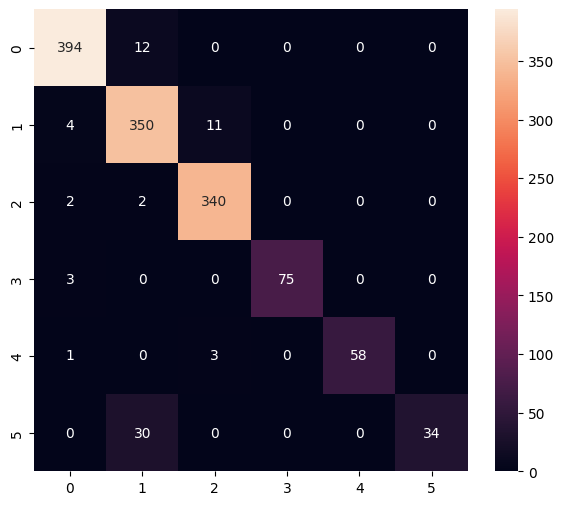

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       406
           1       0.89      0.96      0.92       365
           2       0.96      0.99      0.97       344
           3       1.00      0.96      0.98        78
           4       1.00      0.94      0.97        62
           5       1.00      0.53      0.69        64

    accuracy                           0.95      1319
   macro avg       0.97      0.89      0.92      1319
weighted avg       0.95      0.95      0.95      1319



In [180]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [181]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

C:\Users\Abhishek Gupta\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [182]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ABHISH~1\AppData\Local\Temp\tmpx6fzzqc7\assets


INFO:tensorflow:Assets written to: C:\Users\ABHISH~1\AppData\Local\Temp\tmpx6fzzqc7\assets


6696

# Inference test

In [183]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [184]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [185]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [186]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [187]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.7577828e-01 2.4008863e-02 8.8643006e-05 2.9196255e-05 9.4554372e-05
 4.3589625e-07]
0
